# Data Training, Regularizing, Feature Selection, and Testing

## Packages needed for analysis:

In [7]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# BL: These are just helpful as I debug things
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [8]:
# From: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import timesplit as ts

# import our pipeline file [TO DO: NEEDS TO BE UPDATED TO USE OURS]
import pipeline as pline

## Import cleaned data on a Fips-date level

In [9]:
df = pd.read_csv("../Data/merged.csv", parse_dates=["date"], dtype={'fips': str})
df.head()

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,grocery_pharm,parks,transit,workplace,residential,new doses,cumulative doses,cases_next_week
0,IL,17001,Adams,2020-03-20,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.0,11.0,NaN,-7.0,-22.0,13.0,0.0,0.0,0.0
1,IL,17001,Adams,2020-03-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-55.0,-14.0,NaN,-30.0,-15.0,NaN,0.0,0.0,0.0
2,IL,17001,Adams,2020-03-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-63.0,-42.0,NaN,NaN,-25.0,NaN,0.0,0.0,0.0
3,IL,17001,Adams,2020-03-23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.0,-20.0,NaN,-21.0,-29.0,14.0,0.0,0.0,0.0
4,IL,17001,Adams,2020-03-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-46.0,-20.0,NaN,NaN,-31.0,15.0,0.0,0.0,0.0


## Some gentle data processing to get rid of any remaining NAs

In [10]:
# filter down to dates with hospital
date_mask = (df["date"]>='7-31-2020')
df = df[date_mask]

# drop grocery_pharm, parks, transit because they have too much missingness
df.drop(columns=["grocery_pharm", "parks", "transit", "residential"], inplace = True)

# fill na's with mean for that state that date for retail_rec, workplace [TO DO: IS THIS REASONABLE?]
for var in ["retail_rec", "workplace"]:
    df[var] = df[["state", "date", var]].groupby(["state", "date"]).transform(lambda x: x.fillna(x.mean()))

# fill missing masks with 0 because the missings are from MO, who doesn't have a mask mandate
df["mask_mandate"] = df["mask_mandate"].fillna(0)

# drop na's (should just be the last week for each fips)
df = df.dropna()

df.describe()

,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,workplace,new doses,cumulative doses,cases_next_week
count,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,7.586800e+04,75868.000000,7.586800e+04,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000,7.586800e+04,75868.000000,75868.00000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000,7.586800e+04,75868.000000,75868.000000,7.586800e+04,7.586800e+04,7.586800e+04,7.586800e+04,7.586800e+04,7.586800e+04,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000
mean,5157.038956,93.936726,33.259596,0.545718,33.252610,0.490431,33.163060,0.488717,1.010649e+05,4.957821e+04,49.883645,5.148671e+04,50.117008,6623.409329,6.494273,6742.902739,6.118514,13613.640652,11.630159,12496.415234,11.611020,13089.006722,12.860044,6999.399299,7.333487,6516.170586,6.954919,41.484360,19944.241657,22.809855,16172.431829,18.739208,7.811913e+04,91.350485,1.320622e+04,4.369502,278.88418,0.351894,3543.837600,0.984074,57.968102,0.057165,3122.824326,0.846729,9.541169e+03,3.597140,4.422942e+04,5910.361892,17230.689909,2.126703e+04,2.725623e+04,2.981611e+04,4.601552e+04,6.004560e+04,7.100016e+04,13118.642247,5795.158051,7323.484196,18811.547003,18.270105,2.294580e+04,8.649515,128.749657,1.615530,17.364422,0.172708,0.995940,1.297556,1.772618,2.913442,4.017741,4.449913,4.197409,0.431789,0.621079,-5.193752,-19.133926,164.652027,6.151541e+03,33.395213
std,21473.510024,455.881761,139.108506,3.389662,132.495562,2.312191,132.189254,2.311772,3.366181e+05,1.633324e+05,1.878297,1.732983e+05,1.878500,20755.725326,1.167539,22326.312195,2.293326,53619.880112,1.612048,44659.712118,1.151886,42947.858012,1.001042,21877.550783,0.806341,20210.735079,0.965660,3.978082,60427.031355,3.802161,48782.623904,3.305044,2.025780e+05,7.984876,7.807020e+04,6.396103,951.79296,0.395138,23437.279509,1.431893,212.414736,0.179511,29166.812353,1.400321,7.696449e+04,4.039276,1.434632e+05,21435.238431,61802.948526,7.543365e+04,9.517419e+04,1.034522e+05,1.534677e+05,1.942875e+05,2.274215e+05,47118.377691,20565.455191,26559.104938,62278.526676,1.836000,1.379778e+05,7.984876,577.398184,9.649264,64.672781,1.003362,4.566838,5.725642,7.072201,11.072198,14.216432,14.628187,13.881740,6.612432,0.485122,15.376650,13.507123,854.820695,3.284197e+04,132.947069

## Split test train

I realized that we should probably do all feature selection on only the training data since we shouldn't be touching the test data until the end

In [11]:
from sklearn.model_selection import train_test_split

# split df into features and labels
X = df.drop(columns=["cases_next_week"])
y = df["cases_next_week"]

# split df into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# df that's just training
df_train = pd.concat([X_train, y_train], axis=1)

## Feature Selection

There are three main goals to feature selection:
Improve the accuracy with which the model is able to predict for new data.
Reduce computational cost.
Produce a more interpretable model.

I tried 2 methods from https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d

Feature Selection Sources:
    https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d
    https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
Need to use a model to check which features? I would say Linear for simplicity but not sure that really works with this? So maybe logistic to start and check features and then we can compare other models? Not sure

BL: Not sure how we can use logistic since logistic is only used to predict a binary variable, right?

### Correlations

In [12]:
corr = df_train.corr()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corr['cases_next_week'])
#print(corr['new_cases_7avg'])

cumulative_cases                        0.695749
cumulative_deaths                       0.707731
new_cases                               0.937362
new_deaths                              0.446090
new_cases_7avg                          0.970834
new_deaths_7avg                         0.653476
2weeksago_cases_7avg                    0.872294
2weeksago_deaths_7avg                   0.545951
total_pop                               0.792149
male                                    0.792153
perc_male                              -0.105611
female                                  0.792089
perc_female                             0.105534
age_15_19                               0.790855
p_age_15_19                             0.010195
age_20_24                               0.788588
p_age_20_24                             0.059062
age_25_34                               0.787710
p_age_25_34                             0.274653
age_35_44                               0.791201
p_age_35_44         

In [7]:
# lowest 20 (abs value)
corr['cases_next_week'].abs().sort_values()[:20]

p_age_15_19         0.010195
p_age_45_54         0.024059
p_hawaiian          0.031152
p_native            0.047683
p_under14           0.048403
p_age_20_24         0.059062
mask_mandate        0.091302
perc_female         0.105534
perc_male           0.105611
p_age_55_59         0.122189
p_age_60_64         0.128635
workplace           0.144537
age_median          0.164537
p_age_35_44         0.165079
cumulative doses    0.171821
retail_rec          0.183437
p_age_62over        0.197310
p_age_65over        0.201909
new doses           0.205602
p_age_25_34         0.274653
Name: cases_next_week, dtype: float64

In [8]:
# highest 20 (abs value)
corr['cases_next_week'].abs().sort_values()[-20:]

age_15_19                             0.790855
age_35_44                             0.791201
age_45_54                             0.791629
age_under14                           0.791968
female                                0.792089
total_pop                             0.792149
male                                  0.792153
prev_day_adult_admit_80+_7daysum      0.866537
2weeksago_cases_7avg                  0.872294
prev_day_adult_admit_70-79_7daysum    0.883391
prev_day_adult_admit_20-29_7daysum    0.895391
prev_day_adult_admit_50-59_7daysum    0.899750
prev_day_adult_admit_30-39_7daysum    0.902492
prev_day_adult_admit_60-69_7daysum    0.905927
prev_day_adult_admit_40-49_7daysum    0.912390
prev_day_adult_admit_7daysum          0.921897
total_adult_hospitalizations          0.924556
new_cases                             0.937362
new_cases_7avg                        0.970834
cases_next_week                       1.000000
Name: cases_next_week, dtype: float64

<AxesSubplot:>

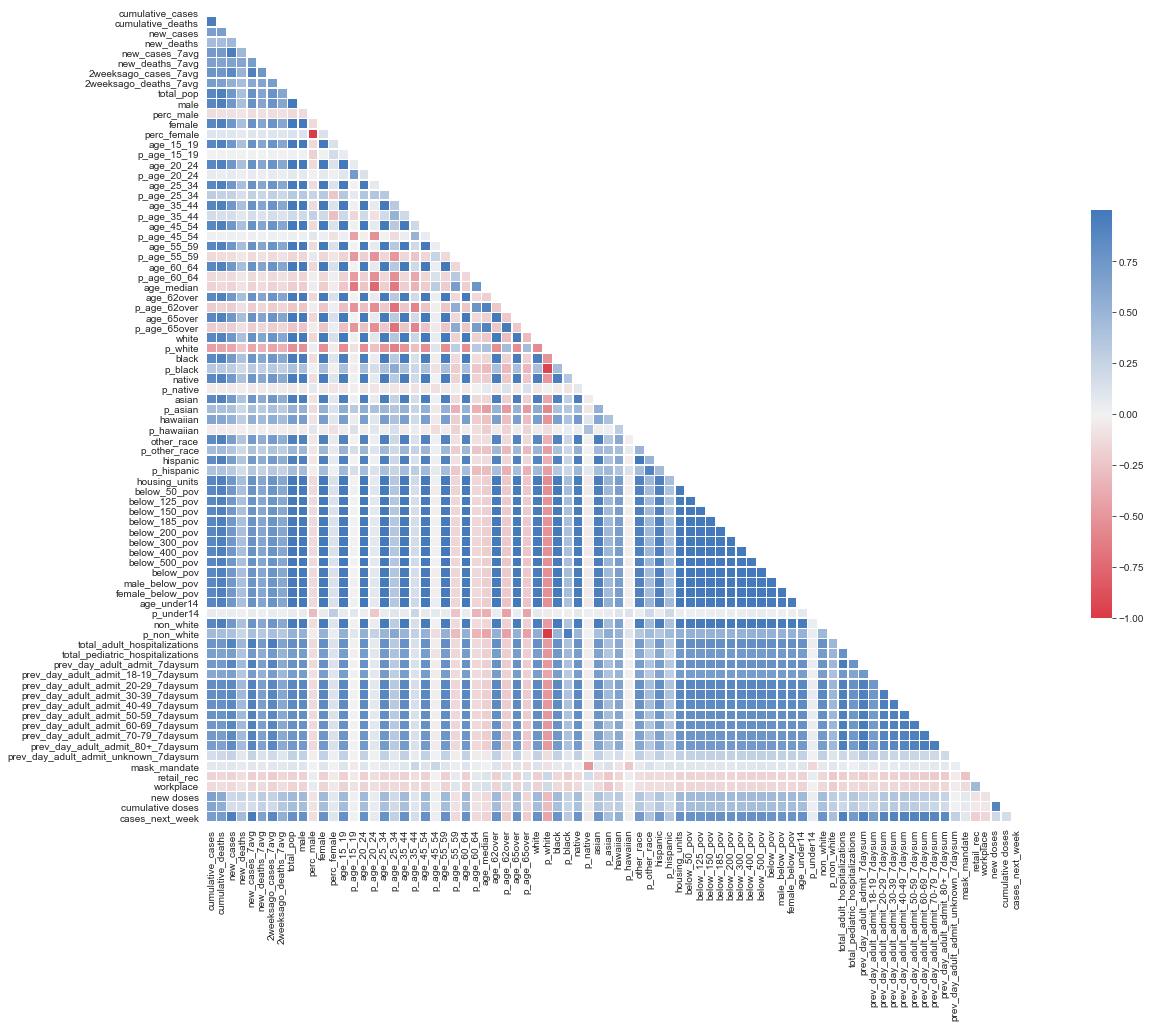

In [9]:
# Correlation plot


# use the pands .corr() function to compute pairwise correlations for the dataframe
#corr = normalized_df.corr()
corr = df_train.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [13]:
def highlight_large(s):
    '''
    highlight large values greater than some threshold.
    '''
    is_large = s.abs() > 0.8
    return ['background-color: yellow' if v else '' for v in is_large]

In [14]:
corr = df_train.corr()
corr.style.apply(highlight_large)

,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,workplace,new doses,cumulative doses,cases_next_week
cumulative_cases,1.000000,0.967135,0.673047,0.440958,0.720341,0.668793,0.773075,0.698734,0.881761,0.881820,-0.105565,0.881643,0.105487,0.878102,0.005482,0.877296,0.057301,0.881610,0.295150,0.883478,0.174356,0.880214,0.017804,0.877543,-0.128852,0.876356,-0.137488,-0.171766,0.875085,-0.204449,0.874627,-0.208610,0.869083,-0.448349,0.861076,0.341623,0.865369,-0.038355,0.857448,0.442412,0.627956,-0.023516,0.837845,0.441005,0.844778,0.394670,0.878362,0.868038,0.871803,0.873316,0.875278,0.875723,0.878410,0.879605,0.880188,0.869509,0.867573,0.870813,0.881785,0.053214,0.875811,0.448349,0.769323,0.682193,0.738525,0.614133,0.814768,0.825250,0.799836,0.784488,0.756054,0.729345,0.697120,0.157193,0.079169,-0.170460,-0.130192,0.666446,0.635694,0.695749
cumulative_deaths,0.967135,1.000000,0.676419,0.426609,0.717260,0.647835,0.745972,0.671626,0.932218,0.932028,-0.097832,0.932330,0.097764,0.923388,-0.012697,0.924556,0.037342,0.935063,0.262013,0.936492,0.149791,0.930241,0.014987,0.926446,-0.104606,0.926775,-0.107240,-0.134956,0.927858,-0.162054,0.927906,-0.165503,0.907155,-0.422265,0.920598,0.319403,0.920226,-0.035889,0.927905,0.410800,0.612628,-0.032324,0.926079,0.446299,0.931334,0.397901,0.927827,0.919616,0.926511,0.928533,0.930433,0.930765,0.931791,0.930817,0.930235,0.922791,0.919460,0.925162,0.928678,0.032007,0.942974,0.422265,0.753024,0.648548,0.721359,0.630947,0.815694,0.827499,0.802724,0.774349,0.738993,0.699430,0.662738,0.207864,0.084948,-0.147312,-0.114039,0.586020,0.561894,0.707731
new_cases,0.673047,0.676419,1.000000,0.461433,0.952386,0.649187,0.857184,0.544204,0.749678,0.749689,-0.100058,0.749614,0.099985,0.748609,0.010104,0.746400,0.056527,0.745223,0.260359,0.748694,0.156664,0.749239,0.022995,0.748482,-0.116147,0.748024,-0.122393,-0.156493,0.747021,-0.187593,0.746653,-0.191966,0.745290,-0.399319,0.726157,0.306875,0.727378,-0.045117,0.719364,0.400224,0.516941,-0.029632,0.691069,0.371780,0.699126,0.335595,0.747812,0.736589,0.738553,0.739778,0.741415,0.741861,0.744849,0.746896,0.748035,0.737251,0.736021,0.738037,0.749538,0.046098,0.735275,0.399319,0.898833,0.687779,0.889272,0.674935,0.857304,0.860376,0.872909,0.863389,0.875499,0.855525,0.838621,0.256515,0.086569,-0.166788,-0.133216,0.210478,0.158918,0.937362
new_deaths,0.440958,0.426609,0.461433,1.000000,0.470334,0.630741,0.508723,0.428224,0.420189,0.419743,-0.065760,0.420580,0.065713,0.418152,-0.004459,0.416024,0.025192,0.414338,0.147626,0.416718,0.079405,0.419828,0.011092,0.422531,-0.058651,0.423851,-0.057336,-0.080175,0.425366,-0.094899,0.425597,-0.098004,0.419061,-0.233984,0.411758,0.189984,0.405123,-0.029965,0.390368,0.208162,0.297544,-0.019329,0.376207,0.197944,0.380609,0.176392,0.422448,0.415370,0.416649,0.417170,0.417998,0.418314,0.419837,0.420923,0.421266,0.416116,0.415089,0.416819,0.418388,0.019

### Variance threshold

"This is one of the most simple approaches to feature selection. The scikit-learn library has a method called VarianceThreshold . This method takes a threshold value and when fitted to a feature set will remove any features below this threshold. The default value for the threshold is 0 and this will remove any features with zero variance, or in other words where all values are the same."

In [12]:
from sklearn.feature_selection import VarianceThreshold
X = X_train.drop(columns=["state", "county", "fips"], axis=1)
selector = VarianceThreshold()
print("Original feature shape:", X.iloc[:, 1:].shape)
new_X = selector.fit_transform(X.iloc[:, 1:])
print("Transformed feature shape:", new_X.shape)

Original feature shape: (60694, 79)
Transformed feature shape: (60694, 79)


^ Looks like there's no variables with 0 variance (which is good).  Should we try setting different variances?

### sklearn's SelectKBest
https://machinelearningmastery.com/feature-selection-for-regression-data/


"Select features according to the k highest scores."

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# get feature selection model
fs = SelectKBest(score_func=mutual_info_regression, k='all')

# learn relationship from training data (drop non-numerical data)
fs.fit(X_train.drop(columns=["date", "state", "fips", "county"]), y_train.drop(columns=["date"]))

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x7fbacc4d83a0>)

In [7]:
feature_scores = pd.DataFrame({'variables': X_train.drop(columns=["date", "state", "fips", "county"]).columns.tolist(), 'score': fs.scores_})

# print out 30 most important features according to SelectKBest
feature_scores.sort_values(by="score", ascending=False).head(30)

,variables,score
4,new_cases_7avg,1.281893
6,2weeksago_cases_7avg,0.822743
2,new_cases,0.816567
11,female,0.723746
8,total_pop,0.721572
9,male,0.720496
46,housing_units,0.719166
21,age_45_54,0.718780
32,white,0.717632
54,below_500_pov,0.717570


## GridSearchCV for feature selection using time-based CV

In [15]:
# get list of numerical features for normalization
numerical_features = X_train.columns.tolist()[4:]
numerical_features.remove('mask_mandate')
numerical_features

# normalize numerical features
X_train, X_test = pline.normalize(X_train, X_test, numerical_features)

# one hot encode categorical variables
X_train = pline.one_hot_encode(X_train, ["state", "fips"])
X_test = pline.one_hot_encode(X_test, ["state", "fips"])

# drop county cause that's the same as fips
X_train = X_train.drop(columns=["county"])
X_test = X_test.drop(columns=["county"])

In [16]:
# set up time-based CV indices
tscv = ts.TimeBasedCV(train_period=21,
                      test_period=7,
                      freq='days')

tscv_indices = []

for train_index, test_index in tscv.split(X_train, date_column='date'):
    tscv_indices.append((train_index, test_index))

In [17]:
# https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration#custom-transformer-example-select-dataframe-columns
# Taken from above link, but this transformer just selects down to the provided variables in the parameter
# We can use this in our pipeline to select down to our n-most correlated variables

class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [13]:
# testing to make sure the transformer works
n_most_correlated = [(corr['cases_next_week'].abs().sort_values()[-21:-1]).index, # 20 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-31:-1]).index, # 30 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-51:-1]).index, # 50 most correlated variables
                    X_train.columns] # all variables

test = SelectColumnsTransformer(n_most_correlated[0])

test.transform(X_train) # works here but I can't get it to work in the pipeline??

,age_55_59,age_15_19,age_35_44,age_45_54,age_under14,female,total_pop,male,prev_day_adult_admit_80+_7daysum,2weeksago_cases_7avg,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_7daysum,total_adult_hospitalizations,new_cases,new_cases_7avg
0,0.338850,0.267989,0.248686,0.286355,0.272201,0.284230,0.275356,0.265922,0.268953,-0.092451,0.372739,0.427449,0.005520,0.28940,-0.072694,0.583900,0.129373,0.068141,-0.025883,-0.041777
1,0.254621,0.254763,0.185021,0.247980,0.224310,0.206382,0.208076,0.209858,-0.087254,-0.166253,-0.099799,-0.216201,0.005520,-0.22516,-0.072694,0.167557,-0.159869,-0.168357,-0.095897,-0.093650
2,-0.115781,-0.146456,-0.117018,-0.114186,-0.128222,-0.120480,-0.122536,-0.124708,-0.300978,-0.181013,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.151909,-0.152933
3,-0.201759,-0.217498,-0.193815,-0.203164,-0.185052,-0.198708,-0.199022,-0.199340,-0.300978,-0.085071,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.186916,-0.108471
4,-0.266936,-0.277960,-0.244261,-0.259859,-0.262499,-0.255010,-0.257155,-0.259411,-0.300978,-0.225295,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.172913,-0.204805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60689,-0.300601,-0.301719,-0.264562,-0.286598,-0.285603,-0.280136,-0.283172,-0.286372,-0.300978,-0.225295,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.235925,-0.227036
60690,-0.006449,-0.016227,0.026120,0.012301,0.011406,-0.006517,-0.004639,-0.002645,-0.087254,-0.195774,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,0.167557,-0.220763,-0.156448,-0.109900,-0.197395
60691,-0.291815,-0.291044,-0.257547,-0.278362,-0.276301,-0.270607,-0.272622,-0.274740,-0.300978,-0.240055,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.228924,-0.249267
60692,-0.125598,-0.134458,-0.131663,-0.130407,-0.117992,-0.128578,-0.128370,-0.128139,-0.300978,-0.173633,-0.302315,-0.216201,-0.261318,-0.22516,-0.072694,-0.248785,-0.220763,-0.200685,-0.172913,-0.189984


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
# list of the n most correlated variables, 
n_most_correlated = [(corr['cases_next_week'].abs().sort_values()[-21:-1]).index, # 20 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-31:-1]).index, # 30 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-51:-1]).index, # 50 most correlated variables
                    X_train.columns] # all variables

scoring_metrics = ["neg_mean_squared_error", "r2"]

pipe = Pipeline([#('selector_ncorr', SelectColumnsTransformer()), # keeps just the n most correlated variables
                 ('feature_selection', SelectKBest()),
                 ('lr', LinearRegression())])
                  #'ridge', Ridge(alpha=0.1))

param_grid = {
    #'selector_ncorr': n_most_correlated,
    'feature_selection__k': [20, 30, 50, 'all'],
    'feature_selection__score_func': [mutual_info_regression]
}

fs_search = GridSearchCV(pipe, param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
fs_search.fit(X_train.drop(columns="date"), y_train.drop(columns="date"))

KeyboardInterrupt: 

In [19]:
def GridSearchSummary(search, hyperparams, metrics, file):
    """
    Creates a dataframe with summary results from GridSearchCV
    search - the final GridSearchCV object
    hyperparams - the list of parameters you were tuning for (aka keys in the param_grid dictionary)
    metrics - the list of scoring metrics you used
    file - filename of where you want to save your results
    """
    
    summary = pd.DataFrame()
    
    for hyperparam in hyperparams:
        col = [dct[hyperparam] for dct in search.cv_results_["params"]]
        summary[hyperparam] = col
    
    for metric in metrics:
        col = search.cv_results_["mean_test_" + metric]
        summary[metric] = col
    
    summary.to_csv(file)
    
    return summary

In [22]:
GridSearchSummary(fs_search, 
                  ["feature_selection__k", "feature_selection__score_func"],
                  ["neg_mean_squared_error", "r2"],
                  "fs_search.csv")

,feature_selection__k,feature_selection__score_func,neg_mean_squared_error,r2
0,20,<function mutual_info_regression at 0x7f7fe93b...,-2.429377e+03,8.985203e-01
1,30,<function mutual_info_regression at 0x7f7fe93b...,-1.491492e+03,9.220480e-01
2,50,<function mutual_info_regression at 0x7f7fe93b...,-1.586805e+03,9.344488e-01
3,all,<function mutual_info_regression at 0x7f7fe93b...,-5.999928e+18,-1.738027e+14


### Regression in the time loop

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [20]:
X_new

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,workplace,new doses,cumulative doses,more_hosp_next_week
133,IL,17001,Adams,2020-07-31,393.0,2.0,30.0,0.0,13.0,0.0,12.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0,1.0,-6.000000,-28.0,0.0,0.0,1
134,IL,17001,Adams,2020-08-01,410.0,3.0,17.0,1.0,14.0,0.0,11.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0,1.0,-20.000000,-8.0,0.0,0.0,1
135,IL,17001,Adams,2020-08-02,424.0,3.0,14.0,0.0,14.0,0.0,12.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0,1.0,-3.000000,-6.0,0.0,0.0,1
136,IL,17001,Adams,2020-08-03,445.0,4.0,21.0,1.0,15.0,0.0,14.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0,1.0,0.000000,-26.0,0.0,0.0,1
137,IL,17001,Adams,2020-08-04,454.0,5.0,9.0,1.0,16.0,1.0,12.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0,1.0,0.000000,-26.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114717,OH,39175,Wyandot,2021-03-31,2214.0,52.0,3.0,0.0,2.0,0.0,5.0,0.0,22000,10835,49.3,11165,50.8,1382,6.3,1243,5.7,2413,11.0,2615,11.9,2901,13.2,1635,7.4,1526,6.9,42.1,4989,22.7,4130,18.8,21372,97.1,36,0.2,0,0.0,183,0.8,0,0.0,154,0.7,660,3.0,9949,635,2748,4361,5659,6054,10550,14155,17446,1611,638,973,4155,18.8,628,2.9,0.0,3.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,14.000000,-17.0,366.0,10370.0,0
114718,OH

In [24]:
scores = []
df["hosp_next_week"]= df['total_adult_hospitalizations'].shift(-7)
df['more_hosp_next_week'] = np.where(df["hosp_next_week"] > df["total_adult_hospitalizations"], 1, 0)
X_new = df.drop(columns=["cases_next_week", "total_adult_hospitalizations", "hosp_next_week"])

y_new = df['more_hosp_next_week']

for train_index, test_index in tscv.split(X_train, date_column='date'):

    data_train   = X_new.iloc[train_index]
    target_train = y_new.iloc[train_index]

    data_test    = X_new.iloc[test_index]
    target_test  = y_new.iloc[test_index]
    
    data_train = pline.one_hot_encode(data_train, ["state", "fips"])
    data_test = pline.one_hot_encode(data_test, ["state", "fips"])

    # get list of numerical features for normalization
    numerical_features = data_train.columns.tolist()[2:]
    numerical_features.remove('mask_mandate')

    # normalize
    data_train, data_test = pline.normalize(data_train, data_test, numerical_features)

    # drop county cause that's the same as fips
    data_train = data_train.drop(columns=["county"])
    data_test = data_test.drop(columns=["county"])
    
    # drop date
    data_train = data_train.drop(columns=["date"])
    data_test = data_test.drop(columns=["date"])


    grid_params = {'lr__penalty':['l2', 'none'],
                   'lr__C':[0.01,0.1,1,10,100],
                   'lr__random_state':[0]
                   #'GaussianNB__priors':[None],
                   #'LinearSVC__C':[0.01,0.1,1,10,100],
                   #'LinearSVC__random_state':[0],
                   #'tree__max_depth':[1,3,5],
                   #'tree__min_samples_split':[2,5,10],
                   #'tree__criterion':["gini","entropy"],
                   #'tree__random_state':[0]
                  }
    # if needed, do preprocessing here
    pipe = Pipeline([
                 ('lr', LogisticRegression())
                  #('LinearSVC', LinearSVC()),
                  #('GaussianNB',GaussianNB()),
                  #('tree', DecisionTreeClassifier())
    ])
                  #'ridge', Ridge(alpha=0.1))

    clf = GridSearchCV(pipe, grid_params, scoring="accuracy",n_jobs=2,verbose=2,cv=10)
    #print(data_train)
    clf.fit(data_train, target_train)

    preds = clf.predict(data_test)

    best=clf.best_estimator_
    results=pd.DataFrame(clf.cv_results_)
    #output=results[["params",""]] # mean_test_accuracy
    print("Best Model",best)
    #output
    #output.style.set_properties(subset=['params'],**{'width':'300px'})
    #print(results)
    print("done")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.8s finished


Best Model Pipeline(steps=[('lr', LogisticRegression(C=0.01, random_state=0))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
0       0.095757      0.004326         0.005358        0.000661        0.01   
1       0.088890      0.007112         0.004931        0.000730        0.01   
2       0.112587      0.013359         0.005162        0.000826         0.1   
3       0.086704      0.007343         0.005160        0.000852         0.1   
4       0.138669      0.014891         0.005733        0.000925           1   
5       0.090628      0.007761         0.005282        0.000818           1   
6       0.139578      0.012925         0.005339        0.000550          10   
7       0.090074      0.007407         0.004948        0.000770          10   
8       0.138112      0.019154         0.004959        0.000799         100   
9       0.091973      0.007941         0.005401        0.000741         100   

  param_lr__penalty param_lr__random_state  \
0   

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.3s finished


Best Model Pipeline(steps=[('lr', LogisticRegression(C=0.01, random_state=0))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
0       0.108075      0.008799         0.006349        0.001059        0.01   
1       0.095759      0.009210         0.004808        0.000666        0.01   
2       0.108220      0.007458         0.004836        0.000590         0.1   
3       0.088566      0.003705         0.005284        0.000452         0.1   
4       0.133901      0.011335         0.005145        0.001114           1   
5       0.087622      0.003918         0.005544        0.000885           1   
6       0.129423      0.014918         0.005433        0.000575          10   
7       0.101812      0.015539         0.005992        0.001027          10   
8       0.170862      0.026624         0.006629        0.001399         100   
9       0.089825      0.016703         0.005487        0.001041         100   

  param_lr__penalty param_lr__random_state  \
0   

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.2s finished


Best Model Pipeline(steps=[('lr', LogisticRegression(C=0.1, random_state=0))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
0       0.088109      0.008315         0.005270        0.000716        0.01   
1       0.087535      0.004193         0.004744        0.000453        0.01   
2       0.100277      0.009469         0.005349        0.000865         0.1   
3       0.102195      0.010984         0.005739        0.000804         0.1   
4       0.149554      0.011095         0.005684        0.000538           1   
5       0.095364      0.012566         0.006132        0.000550           1   
6       0.152764      0.024385         0.006769        0.001301          10   
7       0.120044      0.015143         0.006481        0.001337          10   
8       0.147708      0.020169         0.005935        0.001320         100   
9       0.083867      0.008893         0.005114        0.000475         100   

  param_lr__penalty param_lr__random_state  \
0    

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.5s finished


Best Model Pipeline(steps=[('lr', LogisticRegression(C=0.01, random_state=0))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
0       0.080329      0.007154         0.004889        0.000666        0.01   
1       0.086562      0.005778         0.005216        0.000507        0.01   
2       0.099829      0.006866         0.004489        0.000562         0.1   
3       0.086440      0.006095         0.005597        0.000637         0.1   
4       0.116319      0.008835         0.005199        0.000532           1   
5       0.083132      0.005184         0.005301        0.000666           1   
6       0.124997      0.011891         0.005764        0.000720          10   
7       0.086095      0.014751         0.005466        0.001008          10   
8       0.134707      0.016482         0.006036        0.000996         100   
9       0.088277      0.017375         0.005497        0.000926         100   

  param_lr__penalty param_lr__random_state  \
0   

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.8s finished


Best Model Pipeline(steps=[('lr', LogisticRegression(C=0.01, random_state=0))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
0       0.089886      0.008315         0.005993        0.000768        0.01   
1       0.090199      0.008022         0.004978        0.000770        0.01   
2       0.106986      0.016364         0.005409        0.000732         0.1   
3       0.097161      0.007573         0.005831        0.001004         0.1   
4       0.132415      0.010997         0.005365        0.000635           1   
5       0.086746      0.011787         0.005595        0.001099           1   
6       0.132301      0.013926         0.005754        0.000996          10   
7       0.089435      0.009191         0.005660        0.000810          10   
8       0.136924      0.017055         0.006545        0.001230         100   
9       0.086056      0.009590         0.005696        0.000712         100   

  param_lr__penalty param_lr__random_state  \
0   

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.1s finished


Best Model Pipeline(steps=[('lr', LogisticRegression(C=0.01, random_state=0))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
0       0.095978      0.013840         0.006502        0.000584        0.01   
1       0.102228      0.006995         0.005811        0.000820        0.01   
2       0.117020      0.011956         0.006097        0.000681         0.1   
3       0.101893      0.010734         0.005639        0.000767         0.1   
4       0.138586      0.013838         0.005761        0.001004           1   
5       0.099600      0.014556         0.005790        0.001091           1   
6       0.150902      0.023701         0.006110        0.000751          10   
7       0.088257      0.010758         0.005073        0.000861          10   
8       0.120330      0.011632         0.005164        0.000572         100   
9       0.081822      0.005986         0.004589        0.000547         100   

  param_lr__penalty param_lr__random_state  \
0   

KeyError: "['fips_17101'] not in index"

In [ ]:
# MODELS= {'LogisticRegression':LogisticRegression(solver='lbfgs',max_iter=1000),
#          'LinearSVC':LinearSVC(),
#          'GaussianNB':GaussianNB()}
# print(MODELS.values())
# GRID={'LogisticRegression':[{'penalty':x,'C':y,'random_state':0}
#                             for x in('l2','none') \
#                             for y in(0.01,0.1,1,10,100)],
#     'GaussianNB':[{'priors':None}],
#      'LinearSVC':[{'C':x,'random_state':0} \
#                   for x in(0.01,0.1,1,10,100)]}


## Ridge Regression

In [16]:
from sklearn.linear_model import Ridge

In [ ]:
# code from hw2
for a in np.linspace(0, 1, 10):
    print("alpha =", a)
    ls = Ridge(alpha=a)
    ls.fit(np.array(df_train), np.array(y_train))
    target_predict = ls.predict(np.array(df_test))
    print(ls.coef_)
    print("Bias:", mean_squared_error(ls.predict(np.array(df_train)),np.array(y_train)))
    print("RSS:", np.sum((target_predict - np.array(y_test)) ** 2))
    print("Variance Score:", ls.score(np.array(df_train), np.array(y_train)))
    print("Mean absolute error:", mean_absolute_error(target_predict, np.array(y_test)))
    print("Mean squared error:", mean_squared_error(target_predict, np.array(y_test)))
    print("R-squared:", r2_score(target_predict, np.array(y_test)))
    print('\n')

In [20]:
scoring_metrics = ["neg_mean_squared_error", "r2"]

In [5]:
from sklearn.preprocessing import PolynomialFeatures

In [25]:
poly_degrees = [1, 2, 3, 4]

In [37]:
param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

for deg in poly_degrees:
    poly_features = PolynomialFeatures(degree=deg)
    X_poly = poly_features.fit_transform(X_train.drop(columns=["date"]))
    ridge_fs_search = GridSearchCV(Ridge(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
    ridge_fs_search.fit(X_poly, y_train)
    GridSearchSummary(ridge_fs_search, 
                      ["alpha"],
                      ["neg_mean_squared_error", "r2"],
                      "ridge_fs_search_poly_" + str(deg) + ".csv")

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in so

KeyboardInterrupt: 

In [41]:
#pipe = Pipeline([#('feature_selection', SelectKBest(mutual_info_regression)),
#                 ('poly', PolynomialFeatures(degree=1)),
#                 ('ridge', Ridge())])

param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

#print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

ridge_fs_search = GridSearchCV(Ridge(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
ridge_fs_search.fit(X_train.drop(columns=["date"]), y_train)

GridSearchCV(cv=[([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 132, 139,
                   140, 142, 149, 151, 164, 176, 181, 185, 208, 215, 228, 243,
                   245, 247, 258, 262, 264, ...],
                  [212, 219, 249, 281, 305, 307, 312, 330, 400, 435, 499, 558,
                   779, 797, 798, 872, 889, 1005, 1039, 1076, 1164, 1185, 1210,
                   1212, 1226, 1368, 1397, 1410, 1434, 1454, ...]),
                 ([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 139, 142,
                   176, 212, 215, 219, 228, 243, 24...
                 ([5, 6, 7, 14, 19, 23, 34, 42, 83, 89, 100, 115, 120, 141, 186,
                   206, 210, 217, 221, 251, 261, 267, 271, 282, 285, 286, 319,
                   336, 346, 360, ...],
                  [9, 37, 60, 166, 242, 266, 318, 378, 392, 398, 493, 506, 515,
                   603, 637, 651, 668, 698, 716, 758, 761, 861, 978, 1006, 1011,
                   1062, 1075, 1117, 1125, 1136, ...]), ...],
            

In [42]:
GridSearchSummary(ridge_fs_search, 
                  ["alpha"],
                  ["neg_mean_squared_error", "r2"],
                  "ridge_fs_search.csv")

,alpha,neg_mean_squared_error,r2
0,0.0,-7.296296e+27,-2.113553e+23
1,0.1,-2.249048e+03,9.208073e-01
2,0.2,-2.189723e+03,9.210033e-01
3,0.3,-2.143292e+03,9.212923e-01
4,0.4,-2.104919e+03,9.216329e-01
5,0.5,-2.072001e+03,9.219981e-01
6,0.6,-2.043044e+03,9.223723e-01
7,0.7,-2.017122e+03,9.227464e-01
8,0.8,-1.993617e+03,9.231148e-01
9,0.9,-1.972098e+03,9.234743e-01


In [60]:
rid = pd.read_csv("ridge_fs_search.csv")

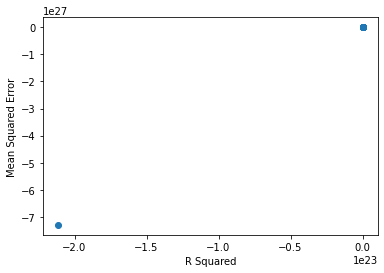

In [61]:
plt.scatter(rid['r2'], rid['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

In [62]:
rid1 = pd.read_csv("ridge_fs_search_poly_1.csv")

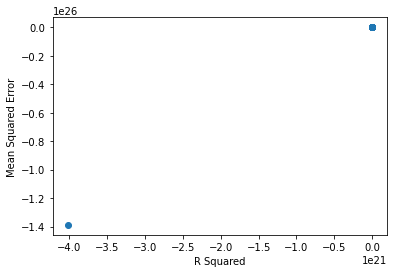

In [63]:
plt.scatter(rid1['r2'], rid1['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

## Lasso Regression

In [4]:
from sklearn.linear_model import Lasso

In [ ]:
# code from hw2
for a in np.linspace(0, 1, 10):
    print("alpha =", a)
    ls = Lasso(alpha=a)
    ls.fit(np.array(df_train), np.array(y_train))
    target_predict = ls.predict(np.array(df_test))
    print(ls.coef_)
    print("Bias:", mean_squared_error(ls.predict(np.array(df_train)),np.array(y_train)))
    print("RSS:", np.sum((target_predict - np.array(y_test)) ** 2))
    print("Variance Score:", ls.score(np.array(df_train), np.array(y_train)))
    print("Mean absolute error:", mean_absolute_error(target_predict, np.array(y_test)))
    print("Mean squared error:", mean_squared_error(target_predict, np.array(y_test)))
    print("R-squared:", r2_score(target_predict, np.array(y_test)))
    print('\n')

to avoid lasso warnings, either increase tol or increase max_iter

In [2]:
from sklearn.pipeline import make_pipeline

not sure if this is okay. did not use tscv_indices here

In [ ]:
for degree in [2, 3, 4]:
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        model = make_pipeline(PolynomialFeatures(degree), Lasso())
        #lasso_fs_search = GridSearchCV(model, alpha, cv=tscv_indices, scoring=scoring_metrics, refit = False)
        model.fit(X_train.drop(columns=["date"]), y_train)
        GridSearchSummary(model, 
                      ["alpha"],
                      ["neg_mean_squared_error", "r2"],
                      "lasso_fs_search_" + str(degree) + ".csv")

In [ ]:

for count, degree in enumerate([2, 3, 4]):
    model = make_pipeline(PolynomialFeatures(degree), Lasso())
    model.fit(X_train.drop(columns=["date"]), y_train)
    

In [46]:
#pipe = Pipeline([#('feature_selection', SelectKBest(mutual_info_regression)),
#                 ('lasso', Lasso())])

param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

#print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

lasso_fs_search = GridSearchCV(Lasso(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
lasso_fs_search.fit(X_train.drop(columns=["date"]), y_train)

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173976.0107155682, tolerance: 18083.44451182775
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330757.67527378607, tolerance: 30882.464165846577
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1041993.1814108839, tolerance: 38470.79049436428
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1980.568187111814, tolerance: 1063.8253983666414
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1964.5833777113003, tolerance: 968.7476579604379
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1297.3522056833608, tolerance: 898.2285074863173
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2453.0173681129527, tolerance: 968.7476579604379
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73675.1412573508, tolerance: 26465.231720459004
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68500.80666112714, tolerance: 23781.626615189874
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

GridSearchCV(cv=[([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 132, 139,
                   140, 142, 149, 151, 164, 176, 181, 185, 208, 215, 228, 243,
                   245, 247, 258, 262, 264, ...],
                  [212, 219, 249, 281, 305, 307, 312, 330, 400, 435, 499, 558,
                   779, 797, 798, 872, 889, 1005, 1039, 1076, 1164, 1185, 1210,
                   1212, 1226, 1368, 1397, 1410, 1434, 1454, ...]),
                 ([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 139, 142,
                   176, 212, 215, 219, 228, 243, 24...
                 ([5, 6, 7, 14, 19, 23, 34, 42, 83, 89, 100, 115, 120, 141, 186,
                   206, 210, 217, 221, 251, 261, 267, 271, 282, 285, 286, 319,
                   336, 346, 360, ...],
                  [9, 37, 60, 166, 242, 266, 318, 378, 392, 398, 493, 506, 515,
                   603, 637, 651, 668, 698, 716, 758, 761, 861, 978, 1006, 1011,
                   1062, 1075, 1117, 1125, 1136, ...]), ...],
            

In [47]:
GridSearchSummary(lasso_fs_search, 
                  ["alpha"],
                  ["neg_mean_squared_error", "r2"],
                  "lasso_fs_search.csv")

,alpha,neg_mean_squared_error,r2
0,0.1,-1468.300266,0.937957
1,0.2,-1452.141940,0.936171
2,0.3,-1463.069275,0.934061
3,0.4,-1472.905511,0.932101
4,0.5,-1471.067356,0.930470
5,0.6,-1468.631660,0.928513
6,0.7,-1474.638626,0.926234
7,0.8,-1481.675223,0.923923
8,0.9,-1488.220795,0.921662
9,1.0,-1496.352447,0.919843


In [57]:
lasso = pd.read_csv("lasso_fs_search.csv")

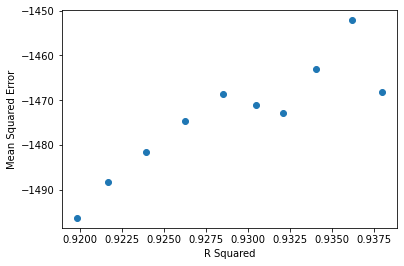

In [58]:
plt.scatter(lasso['r2'], lasso['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

## Elastic Net

In [48]:
from sklearn.linear_model import ElasticNet

In [51]:
#pipe = Pipeline([#('feature_selection', SelectKBest(mutual_info_regression)),
#                 ('ridge', Ridge())])

param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'tol': [0.001]
}

#print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

elastic_net_fs_search = GridSearchCV(ElasticNet(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
elastic_net_fs_search.fit(X_train.drop(columns=["date"]), y_train)

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202210.1476162996, tolerance: 10584.017137251069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238094.86180187695, tolerance: 10808.897115437027
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299132.90986245463, tolerance: 11449.158682716774
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314645.9946016263, tolerance: 16862.873123025933
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184802.7311197895, tolerance: 11781.93706458454
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122516.58667629302, tolerance: 10638.253983666413
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1817272.5628989215, tolerance: 138395.03557614214
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1776756.4943420114, tolerance: 146368.44989701896
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1796642.388435027, tolerance: 130201.88769034256
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2424035.9786287537, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1843336.3069295671, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1285725.9223529492, tolerance: 264652.31720459
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278652.5692710725, tolerance: 23728.157453978154
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 385230.433677517, tolerance: 40886.04310893034
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404125.9812145046, tolerance: 82295.48280580621
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31559.552382943453, tolerance: 10555.091896733817
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47223.15001941682, tolerance: 10870.238425857004
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25255.282539414387, tolerance: 8982.285074863174
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16484.004454626804, tolerance: 9687.476579604378
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23380.27934306918, tolerance: 10773.817220498086
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44375.97359624249, tolerance: 14881.53949796787
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22968.001490250026, tolerance: 9687.476579604378
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14736.155797411397, tolerance: 10773.817220498086
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42069.620097587496, tolerance: 10584.017137251069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12581.888448882062, tolerance: 10638.253983666413
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17455.16210463812, tolerance: 9687.476579604378
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25791.44984569194, tolerance: 10773.817220498086
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601988.6920294525, tolerance: 237816.26615189874
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565835.3259751608, tolerance: 159180.66257872005
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548878.4539485292, tolerance: 133298.47207123289
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369288.1002855918, tolerance: 146368.44989701896
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161450.61104410572, tolerance: 130201.88769034256
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247797.5661379596, tolerance: 10584.017137251069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1059879.5407846689, tolerance: 48791.790799999995
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609308.8656512257, tolerance: 25843.731987958825
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406536.08959415497, tolerance: 16862.873123025933
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1496209.7195119255, tolerance: 130201.88769034256
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 774998.5706265919, tolerance: 77962.14875435206
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476688.8639496244, tolerance: 48791.790799999995
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28100.05547689105, tolerance: 16862.873123025933
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32547.171641943743, tolerance: 11781.93706458454
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20185.870123699307, tolerance: 10638.253983666413
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1690447.316868966, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1487802.2695175624, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 679135.1451757245, tolerance: 264652.31720459
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1612055.9250094062, tolerance: 384707.90494364273
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1192274.2630662406, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1195836.2535099501, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253418.87844524253, tolerance: 159180.66257872005
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336682.16312447516, tolerance: 133298.47207123289
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 731736.1121515279, tolerance: 138395.03557614214
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4495807.328341281, tolerance: 384707.90494364273
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4409924.17788836, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3125637.1315862667, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693102.4898642426, tolerance: 133298.47207123289
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1221511.8962242901, tolerance: 138395.03557614214
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1305036.1451468677, tolerance: 146368.44989701896
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 690241.206690135, tolerance: 384707.90494364273
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 657798.18412787, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025578.4591454219, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311289.4551464163, tolerance: 133298.47207123289
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 743154.266573701, tolerance: 138395.03557614214
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347589.47036260413, tolerance: 146368.44989701896
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292978.73053649394, tolerance: 146368.44989701896
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306266.3220374032, tolerance: 10584.017137251069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339701.0581827491, tolerance: 10808.897115437027
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 792237.7525193107, tolerance: 25843.731987958825
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517836.0966686349, tolerance: 16862.873123025933
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272556.51242844446, tolerance: 11781.93706458454
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338478.2592501091, tolerance: 138395.03557614214
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543555.1429625838, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345441.1260453563, tolerance: 264652.31720459
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6529475.992779043, tolerance: 308824.6416584657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5386493.113546081, tolerance: 384707.90494364273
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5452935.014829604, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383570.1261844875, tolerance: 10808.897115437027
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442949.3955841085, tolerance: 11449.158682716774
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496506.88121612626, tolerance: 10555.091896733817
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311205.72449560155, tolerance: 11781.93706458454
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208903.2135076379, tolerance: 10638.253983666413
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196445.62887878774, tolerance: 9687.476579604378
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3312505.714697464, tolerance: 138395.03557614214
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3068864.63399034, tolerance: 146368.44989701896
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3425476.666990982, tolerance: 130201.88769034256
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6553068.485989988, tolerance: 384707.90494364273
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6699017.9756502025, tolerance: 359945.8277124927
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4745478.883247863, tolerance: 320070.6192159358
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428519.7474948616, tolerance: 9977.441388455536
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 737594.1055839809, tolerance: 13425.111661284047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1569344.6859317305, tolerance: 23728.157453978154
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423091.7544886842, tolerance: 10584.017137251069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456185.73875466385, tolerance: 10808.897115437027
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517634.79414767155, tolerance: 11449.158682716774
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708642.7569915853, tolerance: 16862.873123025933
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375424.4980417723, tolerance: 11781.93706458454
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260632.12686458393, tolerance: 10638.253983666413
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

GridSearchCV(cv=[([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 132, 139,
                   140, 142, 149, 151, 164, 176, 181, 185, 208, 215, 228, 243,
                   245, 247, 258, 262, 264, ...],
                  [212, 219, 249, 281, 305, 307, 312, 330, 400, 435, 499, 558,
                   779, 797, 798, 872, 889, 1005, 1039, 1076, 1164, 1185, 1210,
                   1212, 1226, 1368, 1397, 1410, 1434, 1454, ...]),
                 ([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 139, 142,
                   176, 212, 215, 219, 228, 243, 24...
                   336, 346, 360, ...],
                  [9, 37, 60, 166, 242, 266, 318, 378, 392, 398, 493, 506, 515,
                   603, 637, 651, 668, 698, 716, 758, 761, 861, 978, 1006, 1011,
                   1062, 1075, 1117, 1125, 1136, ...]), ...],
             estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1],
                

In [53]:
GridSearchSummary(elastic_net_fs_search, 
                  ["alpha", "l1_ratio"],
                  ["neg_mean_squared_error", "r2"],
                  "elastic_net_fs_search.csv")

,alpha,l1_ratio,neg_mean_squared_error,r2
0,0.1,0.0,-1321.945161,0.920334
1,0.1,0.1,-1310.308568,0.921310
2,0.1,0.2,-1279.672603,0.923504
3,0.1,0.3,-1267.707455,0.925131
4,0.1,0.4,-1279.164115,0.925568
...,...,...,...,...
105,1.0,0.6,-1606.888053,0.895273
106,1.0,0.7,-1545.768994,0.899399
107,1.0,0.8,-1473.729971,0.904731
108,1.0,0.9,-1411.800183,0.911935


In [54]:
elastic = pd.read_csv("elastic_net_fs_search.csv")

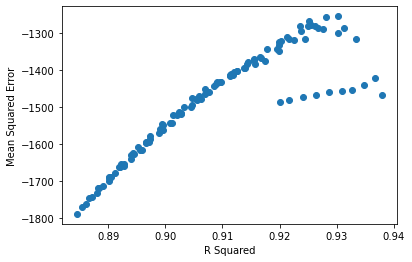

In [56]:
plt.scatter(elastic['r2'], elastic['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

## Support Vector Regression

In [44]:
import datetime
from sklearn import svm

# define scoring metrics
scoring_metrics = ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"]

First use GridSearchCV to determine that best features to use for svm

In [45]:
pipe = Pipeline([('feature_selection', SelectKBest(mutual_info_regression)),
                 ('svm', svm.SVR())])

param_grid = {
    'feature_selection__k': [20, 30, 50]
}

print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

svm_fs_search = GridSearchCV(pipe, param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
svm_fs_search.fit(X_train.drop(columns=["date"]), y_train)

print("End: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

Start:  26/05/2021 12:11:39
End:  26/05/2021 12:30:13


In [3]:
GridSearchSummary(svm_fs_search, 
                  ["feature_selection__k"],
                  scoring_metrics,
                  "svm_fs_search.csv")

,feature_selection__k,neg_mean_squared_error,r2,neg_mean_absolute_error
0,20,-15403.454120,0.314553,-17.659826
1,30,-15438.524153,0.313786,-17.498430
2,50,-16999.255885,0.226491,-19.085698


Then use GridSearchCV to determine which parameters to use for svm, using SelectKBest to narrow down the features and using the k value from above that performed the best

In [ ]:
pipe = Pipeline([('feature_selection', SelectKBest(mutual_info_regression, k=30)), # update k here
                 ('svm', svm.SVR())])

param_grid = {
    'svm__kernel': ["linear", "poly", "rbf"],
    'svm__degree': [2, 3],
    'svm__gamma': ["scale", "auto"],
    'svm__C': [0.5, 1, 5]
}

print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

svm_search = GridSearchCV(pipe, param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
svm_search.fit(X_train.drop(columns=["date"]), y_train)

print("End: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

In [6]:
svm_summary = GridSearchSummary(svm_search, 
                  ["svm__kernel", "svm__gamma", "svm__degree", "svm__C"],
                  scoring_metrics,
                  "svm_search.csv")

svm_summary.sort_values(by=["neg_mean_absolute_error"])

,svm__kernel,svm__gamma,svm__degree,svm__C,neg_mean_squared_error,r2,neg_mean_absolute_error
1,poly,scale,2,0.5,-4233.168843,0.794991,-23.058121
4,poly,auto,2,0.5,-4096.468358,0.796689,-22.951308
13,poly,scale,2,1.0,-3655.790617,0.818902,-21.834902
16,poly,auto,2,1.0,-3459.258209,0.826558,-21.541789
10,poly,auto,3,0.5,-3361.461751,0.828307,-21.092637
7,poly,scale,3,0.5,-3343.708885,0.829520,-21.065286
19,poly,scale,3,1.0,-3306.925817,0.834709,-20.728445
22,poly,auto,3,1.0,-3220.636671,0.836517,-20.663338
31,poly,scale,3,5.0,-3227.217278,0.846174,-19.748878
28,poly,auto,2,5.0,-2956.476404,0.836670,-19.707497


From the above, we see that the best model is the SVM with a linear kernel, using gamma='scale' and C = 0.5

In [14]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn import svm

In [17]:
from sklearn.pipeline import make_pipeline

final_svm = make_pipeline(SelectKBest(mutual_info_regression, k=30), 
                          svm.SVR(kernel="linear", C=5, gamma='scale', degree=3))
final_svm.fit(X_train.drop(columns=["date"]), y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=30,
                             score_func=<function mutual_info_regression at 0x1a122fabf8>)),
                ('svr', SVR(C=5, kernel='linear'))])

In [18]:
predictions = final_svm.predict(X_test.drop(columns=["date"]))

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("MAE: ", mean_absolute_error(y_test, predictions))
print("MSE: ", mean_squared_error(y_test, predictions))
print("Bias:", mean_squared_error(final_svm.predict(X_train.drop(columns="date")),np.array(y_train)))

MAE:  6.645979748124849
MSE:  488.29377374473796
Bias: 957.8640977266842


In [20]:
from sklearn.metrics import r2_score

print("RSS:", np.sum((predictions-y_test)**2))
print("Variance:", final_svm.score(X_train.drop(columns="date"), y_train.drop(columns="date")))
print("R-squared:", r2_score(predictions, y_test))

RSS: 7409369.722802654
Variance: 0.9486144396720491
R-squared: 0.963268331469342


### Random Forest

In [23]:
import datetime
from sklearn.ensemble import RandomForestRegressor

# define scoring metrics
scoring_metrics = ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"]

Feature Selection for Random Forest Regressor

In [24]:
pipe = Pipeline([('feature_selection', SelectKBest(mutual_info_regression)),
                 ('rf', RandomForestRegressor())])

param_grid = {
    'feature_selection__k': [20, 30, 50]
}

print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

rf_fs_search = GridSearchCV(pipe, param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
rf_fs_search.fit(X_train.drop(columns=["date"]), y_train)

print("End: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

GridSearchSummary(rf_fs_search, 
                  ["feature_selection__k"],
                  scoring_metrics,
                  "rf_fs_search.csv")

Start:  27/05/2021 16:24:29
End:  27/05/2021 18:08:57


,feature_selection__k,neg_mean_squared_error,r2,neg_mean_absolute_error
0,20,-1799.560262,0.912886,-9.240047
1,30,-1169.667496,0.936200,-8.098385
2,50,-845.047219,0.952023,-7.299217


Random Forest Model

In [ ]:
pipe = Pipeline([('feature_selection', SelectKBest(mutual_info_regression, k=30)), # update k here
                 ('rf', RandomForestRegressor())])
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param_grid = {
    'rf__criterion': ['mse', 'mae'],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth': max_depth,
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

rf_search = GridSearchCV(pipe, param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
rf_search.fit(X_train.drop(columns=["date"]), y_train)

print("End: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

Start:  27/05/2021 18:21:13


In [ ]:
rf_summary = GridSearchSummary(rf_search, 
                  ["rf__criterion", "rf__max_features", "rf__max_depth", "rf__min_samples_split", "rf__min_samples_leaf"],
                  scoring_metrics,
                  "rf_search.csv")

print(rf_search.best_estimator_)
rf_summary.sort_values(by=["neg_mean_absolute_error"])

## ~Resolved or scratch work~

### Missouri Spike -> Now resolved in data cleaning step

In [ ]:
new_cases_state = df.groupby(["date","state"])["new_cases_7avg"].sum().unstack()
new_cases_state = new_cases_state.fillna(0)
new_cases_state
new_cases_state.plot(figsize=(20,10))
plt.title("Number of New Cases by Date (7 day average)")
plt.ylabel("New Cases (7 day average)")
plt.xlabel("Date")
plt.show()

Based on the above chart, clearly there is something wrong with March 8 for Missouri. According to research, they dumped probable cases into the system that day. Therefore, we will replace with the average of the previous 7 days.
This is also the case with Ohio December 8.

**Question: Do we need to adjust the 7 day average count with this information?**

BL: replotted above with the 7 day average variable that's already in the dataset, but seems like there's still a huge jump at those dates.  Maybe we can impute and add those cases proportionally to the prior dates? 

In [ ]:
# from datetime import date
# df.dtypes
# # Since the data is on FIPS level, not sure best way to do this? 
# df["rolling_mean"] = df["new_cases"].rolling(7).mean().shift(1)

# #Missouri
# mask1 = (df['Date'] == date(2021, 3, 8)) & (df.state == "MO")
# #Ohio
# mask2 = (df['Date'] == date(2020, 12, 8)) & (df.state == "OH")

# df.loc[mask1, 'new_cases'] = df["rolling_mean"]
# df.loc[mask2, 'new_cases'] = df["rolling_mean"]
# df

In [ ]:
df[(df['state']=='MO') & ((df['date']>= '2021-03-01') & (df['date']<= '2021-04-01'))]

In [ ]:
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().unstack().plot(figsize=(20,10))
plt.title("")
plt.ylabel("New Cases (7 day average)")
plt.xlabel("Date")
plt.show()

In [ ]:
print("MO average of new_cases_7avg, over two weeks before 03/07/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-07'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

In [ ]:
print("MO average of new_cases, over two weeks before 03/07/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-07'))].groupby(["date","state"])["new_cases"].sum().mean()

In [ ]:
print("MO average of new_cases_7avg, 03/08/21 to 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-08') & (df['date']<= '2021-03-14'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

In [ ]:
print("MO average of new_cases, 03/08/21 to 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-08') & (df['date']<= '2021-03-14'))].groupby(["date","state"])["new_cases"].sum().mean()

In [ ]:
print("MO average of new_cases_7avg, over two weeks after 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-14') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

In [ ]:
print("MO average of new_cases, over two weeks after 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-14') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases"].sum().mean()

In [ ]:
print("MO average of new_cases_7avg, 02/22/21 to 03/29/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

In [ ]:
print("MO average of new_cases_7avg, 02/22/21 to 03/11/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-11'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

In [ ]:
print("MO average of new_cases_7avg, 03/11/21 to 03/29/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-11') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

I feel like we could potentially replace MO data from 03/08/21 - 03/14/21 with any of the values above. In the end, this is not that many days that we would be changing

I'm less concerned about the spike in OH from December. I feel like that one is less extreme.

In [ ]:
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum()

In [ ]:
df['date'].min()

In [ ]:
df['date'].max()

### Exploration of TimeSeriesSplit -> Determined not usable

In [ ]:
#If using sklearn - How do we account for keeping Fips together? I dont think this can:
# Here are some alternatives: https://stackoverflow.com/questions/51963713/cross-validation-for-grouped-time-series-panel-data

tss = TimeSeriesSplit(n_splits = 3)
# Probably will want to take more variables out
X = df.drop(labels=['new_cases'], axis=1)
y = df['new_cases']
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


Thoughts on splitting with timeseriessplit:
    - if we go with this, I would do a much later n_splits (either # of months in our dataset, or # weeks/3)
    - what if we grouped by fips (and agg) before doing the timeseries split (I guess we would still have multiple rows per date)
    - what if we zoomed out to state level, and made 4 different models for each state. then we could group by date/state and run everything x4 to get us to 1 row per date
   

### Correlations run with normalized features -> Doesn't work as well as correlations on un-normalized features

In [ ]:
normalized_df = X.merge(y, left_index=True, right_index=True)

In [ ]:
normalized_df

I tried doing this with the normalized df and it didn't work so well

### original TimeBasedCV loop -> now wrapped into GridSearchCV

In [ ]:
# one hot encode, 
df_encoded = one_hot_encode(df, ["state", "fips"])

# drop all rows with any na's just to get a model through
df_encoded = df_encoded.dropna()


tscv = ts.TimeBasedCV(train_period=21,
                      test_period=7,
                      freq='days')

# split df into features and labels
X = df_encoded.drop(columns=["cumulative_cases", "cumulative_deaths",
                     "new_cases", "new_deaths",
                     "new_cases_7avg", "new_deaths_7avg", "county",
                     "age_under14", "p_under14"])

y = df_encoded["new_cases_7avg"]

# get list of numerical features
numerical_features = X.columns.tolist()[4:]
numerical_features.remove('mask_mandate')
numerical_features

# create list for scores
r2s = []
mses = []

# grabbed most of this from the towards data science article
for train_index, test_index in tscv.split(X, date_column='date'):

    data_train   = X.loc[train_index].drop('date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here
    
    # normalize numerical features
    data_train, data_test = normalize(data_train, data_test, numerical_features)

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)
    r2s.append(r2score)
    
    mse = mean_squared_error(target_test, preds, squared=True)
    mses.append(mse)

In [ ]:
# average r2 on each fold (on our heavily subsetted data)
average_r2score = np.mean(r2s)
average_r2score

In [ ]:
# average mse on each fold (on our heavily subsetted data)
average_mse = np.mean(mses)
average_mse

### Identified Data Issues - now resolved in data cleaning
Data issues we're going to have to fix:
- variables like p_age...over have -1's
- under 14 variables (like "p_under14" and "age_under14") have weird values that seem either too high or have too many decimal points
- We're going to have to deal with the missingness in our dataset because linear regression can't have missing values
    - missingness in hospitals data
    - missingness in mobility data (some columns have NaN's sprinkled throughout so can we fill in those NaN's by interpolating?)
    - some missingness in mask data but I think we can update data to make it slightly better